Example. As an example we apply least squares classification to the MNIST data set described in §4.3. The (training) data set contains 60,000 images of size 28 by 28. The number of examples per digit varies between 5421 (for digit five) and 6742 (for digit one). The pixel intensities are scaled to lie between 0 and 1. There is also a separate test set containing 10000 images.

In [1]:
import struct
import gzip
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create dictionaries to store the data
train = dict()
test = dict()

In [3]:
def get_images(filename):
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, size, rows, cols = struct.unpack(">IIII", f.read(16))
        images = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return images.reshape(size, rows,cols)

train['image'] = get_images('train-images-idx3-ubyte.gz')
test['image'] = get_images('t10k-images-idx3-ubyte.gz')

In [4]:
def get_labels(filename):
    with gzip.GzipFile(Path('mnist', filename), 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        labels = np.frombuffer(f.read(), dtype=np.dtype('B'))
    return labels

In [5]:
train['label'] = get_labels('train-labels-idx1-ubyte.gz')
test['label'] = get_labels('t10k-labels-idx1-ubyte.gz')

For each digit, we can define a Boolean classifier that distinguishes the digit from the other nine digits. Here we will consider classifiers to distinguish the digit zero. In a first experiment, we use the n = 28 × 28 = 784 pixel intensities as features in the least squares classifier (12.1). 

The vectorized form of least squares can be written as:
$$ 
y = X\beta + \epsilon
$$

where $\beta$ is the population parameters and $\hat{\beta}$ is the estimate of the population parameters.
$$
e = y - X\hat{\beta}
$$

The goal of OLS (ordinary least squares) is to minimize the sum of squared residuals $\epsilon'\epsilon$:


The full derivation is at https://web.stanford.edu/~mrosenfe/soc_meth_proj3/matrix_OLS_NYU_notes.pdf and yields:
$$
\beta=(X'X)^{-1}X'y
$$

In [6]:
X = train['image'].reshape(60000, 28*28)/255
y = (train['label']>0).astype(int)*-2 + 1

$(X'X)^{-1}$ can not be computed because $(X'X)$ is a singular matrix and so not invertible. Instead, use Singular Value Decomposition where the matrix $X$ can be factored into:
$$
X = U\Sigma V'
$$

and it can be shown (https://math.stackexchange.com/q/19954) that:
$$ 
(X'X)^{-1}X = V\Sigma^{-1}U'
$$



In [7]:
# Instead use Singular Value Decomposition:
u, s, vt = np.linalg.svd(X, full_matrices=False)

In [8]:
X_pinv = (vt.T*(1/s)).dot(u.T)

In [9]:
beta = X_pinv.dot(y)

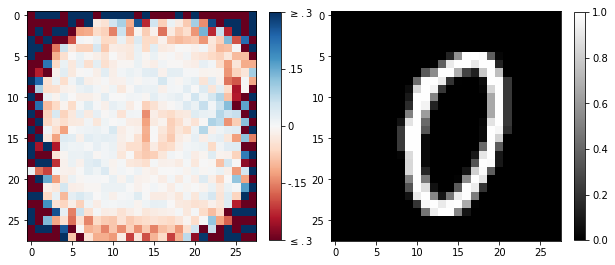

In [10]:
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(10,5))
im = ax.imshow(beta.reshape(28,28), cmap="RdBu", vmin=-.3, vmax=.3)
cb = fig.colorbar(im, ax=ax, fraction=.045)
cb.set_ticks([-.3, -.15, 0, .15, .3])
cb.set_ticklabels([r"$\leq.3$", "-.15", "0", ".15", "$\geq.3$"])

im2 = ax2.imshow(X[1000].reshape(28,28), cmap='gray')
cb2 = fig.colorbar(im2, ax=ax2, fraction=.045)

In [11]:
yhat = np.sign(X.dot(beta))

In [12]:
tp = ((y==1) & (yhat==1)).sum()
tn = ((y==-1) & (yhat==-1)).sum()
fp = ((y==-1) & (yhat==1)).sum()
fn = ((y==1) & (yhat==-1)).sum()

print(f"{tp:<6} {fn:<6} {tp+fn:<6}")
print(f"{fp:<6} {tn:<6} {fp+tn:<6}")
print(f"{tp+fp:<6} {fn+tn:<6}")

5349   574    5923  
325    53752  54077 
5674   54326 


In [13]:
xt = (test['image'].reshape(10000, -1)/255)
yt = (test['label']>0).astype(int)*-2 + 1

yhat_t = np.sign(xt.dot(beta))

tp = ((yt==1) & (yhat_t==1)).sum()
tn = ((yt==-1) & (yhat_t==-1)).sum()
fp = ((yt==-1) & (yhat_t==1)).sum()
fn = ((yt==1) & (yhat_t==-1)).sum()

print(f"{tp:<6} {fn:<6} {tp+fn:<6}")
print(f"{fp:<6} {tn:<6} {fp+tn:<6}")
print(f"{tp+fp:<6} {fn+tn:<6}")

918    62     980   
62     8958   9020  
980    9020  
